## Cats vs Dogs classification with a small dataset

We are going to use the Kaggle competition [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset with over 25k labelled images in the train set. We are going to use only a small part of the dataset for our purposes:

- 2k images for training (1k cats + 1k dogs)
- 2k images for validation (model selection)
- 2k images for testing

The prepared dataset temporarily is available [here](http://rs1.sze.hu/~katihi/titkos/cats_vs_dogs.zip).

See a related article: Elson, J., Douceur, J. R., Howell, J., & Saul, J. (2007). Asirra: a CAPTCHA that exploits interest-aligned manual image categorization

In [1]:
from keras.initializers import he_normal
from keras.regularizers import L2
from keras.optimizers import SGD, Adam, RMSprop, AdamW
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.datasets import mnist, cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Activation, AveragePooling2D, Conv2D, Add 
from keras.layers import MaxPooling2D, Reshape, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical, plot_model, set_random_seed

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

if 1:
    import requests
    import zipfile
    import io
    
    url = "http://rs1.sze.hu/~katihi/titkos/cats_vs_dogs.zip"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(".") 
        print("File downloaded and extracted successfully!")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and extracted successfully!


### Let's build some simple models for baseline

Since we are working with such a small number of images, we definitely need the ImageDataGenerator modifications for the images.

With the `flow_from_directory` function we can specify:
- the directory we want to read the data from
- `target_size`: the shape we want to resize to
- `batch_size`

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "cats_vs_dogs/train/"

train_datagen = ImageDataGenerator(rescale=1/255,
               width_shift_range=0.1,
               height_shift_range=0.1,
               horizontal_flip=True)

train_flow = train_datagen.flow_from_directory(directory=train_dir,
                                  target_size=(256, 256),
                                  class_mode="binary",
                                  batch_size=32,
                                  seed=42)

Found 2000 images belonging to 2 classes.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_flows(width, height, batch_size=32):
    #VGG input shape is: 224*224, InceptionResNetV2 input shape is 299*299

    train_dir = "cats_vs_dogs/train/"
    val_dir =   "cats_vs_dogs/validation/"
    test_dir =  "cats_vs_dogs/test/"
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True)

    train_flow = train_datagen.flow_from_directory(directory=train_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    val_datagen = ImageDataGenerator(rescale=1/255)  # we can experiment: whether to use augmentation or not

    val_flow = val_datagen.flow_from_directory(directory=val_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)
    
    test_datagen = ImageDataGenerator(rescale=1/255)  # we don't need augmentation

    test_flow = test_datagen.flow_from_directory(directory=test_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    return train_flow, val_flow, test_flow

In [4]:
width, height, batch_size = 64, 64, 32

train_flow, val_flow, test_flow = create_flows(width, height, batch_size)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Simple CNN with MaxPooling/GlobalAveragePooling

Let's build a very simple CNN model for binary classification (we have two classes) with

- 2 consecutive Conv2D layers
- (1 MaxPooling layer + a flattening layer) or (1 GlobalAveragePooling)
- 2 fully connected Dense layers

In [7]:
width, height, batch_size = 64, 64, 32

model = Sequential([
    Input(shape=(width, height, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")  # sigmoid for binary, softmax for categorical
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,204,705 (16.04 MB)

 Trainable params: 4,204,705 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

# Reduce model complexity

In [8]:
width, height, batch_size = 64, 64, 32

model = Sequential([
    Input(shape=(width, height, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
    Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")  # sigmoid for binary, softmax for categorical
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,121 (2.01 MB)

 Trainable params: 527,121 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=Adam())

model.fit(train_flow,
          epochs=10,
          validation_data=val_flow)

model.evaluate(test_flow)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5115 - loss: 0.7429 - val_accuracy: 0.5740 - val_loss: 0.6827
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6168 - loss: 0.6587 - val_accuracy: 0.6245 - val_loss: 0.6473
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6555 - loss: 0.6313 - val_accuracy: 0.6100 - val_loss: 0.6716
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6322 - loss: 0.6409 - val_accuracy: 0.6100 - val_loss: 0.6556
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6474 - loss: 0.6280 - val_accuracy: 0.6750 - val_loss: 0.6033
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6631 - loss: 0.6017 - val_accuracy: 0.6560 - val_loss: 0.6160
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6998 - loss: 0.5827 - val_accuracy: 0.6980 - val_loss: 0.5850
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7018 - loss: 0.5875 - val_accuracy: 0.6140 - val_loss: 0.

[0.5756322145462036, 0.6990000009536743]

In [7]:
early_stop = EarlyStopping(patience=7, monitor="val_loss", mode="min", restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=3, monitor="val_loss", mode="min", factor=0.3)

width, height, batch_size = 64, 64, 32

train_flow, val_flow, test_flow = create_flows(width, height, batch_size)

model = Sequential([
    Input(shape=(width, height, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
    Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")  # sigmoid for binary, softmax for categorical
])

model.summary()

model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=Adam())

model.fit(train_flow,
          epochs=10000,
          callbacks=[early_stop, reduce_lr],
          validation_data=val_flow)

model.evaluate(test_flow)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,121 (2.01 MB)

 Trainable params: 527,121 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.5046 - loss: 0.7263 - val_accuracy: 0.6030 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 2/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6158 - loss: 0.6720 - val_accuracy: 0.5655 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 3/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6148 - loss: 0.6494 - val_accuracy: 0.6310 - val_loss: 0.6377 - learning_rate: 0.0010
Epoch 4/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6615 - loss: 0.6233 - val_accuracy: 0.5870 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 5/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6698 - loss: 0.6171 - val_accuracy: 0.6815 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 6/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.7041 - loss: 0.5812 - val_accuracy: 0.6745 - val_loss: 0.6059 - learning_rate: 0.0010
Epoch 7/10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7

[0.5525012612342834, 0.7285000085830688]

## Transfer learning

We are going to use an already pre-trained model with its weights and just change the final dense/prediction layers.
Available pre-trained models in Keras can be found [here](https://keras.io/api/applications/)

These models were trained on millions of images and 1000 classes on the ImageNet challenge dataset. Those classes contain several cat and dog breeds.

In [10]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

 - We have to change the prediction layer to two classes
 - We need to freeze most of the layers we don't want re-train the whole model, and only unfreeze the final few layers.

In [14]:
new_vgg_model = Sequential(vgg_model.layers[:-1])

new_vgg_model.add(Dense(1, activation="sigmoid"))

new_vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 134,264,641 (512.18 MB)

 Non-trainable params: 0 (0.00 B)

- We freeze the VGG layers (set their weights non-trainable)
- cut the prediction layer
- replace it with our Dense layers

In [11]:
new_vgg_model = Sequential()

for layer in vgg_model.layers[:-1]:
    layer.trainable = False
    new_vgg_model.add(layer)

new_vgg_model.add(Dense(1, activation="sigmoid"))

new_vgg_model.summary()

new_vgg_model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=Adam())

train_flow, val_flow, test_flow = create_flows(224, 224, batch_size)

new_vgg_model.fit(train_flow,
          epochs=10,
          validation_data=val_flow)

new_vgg_model.evaluate(test_flow)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 625ms/step - accuracy: 0.5447 - loss: 0.6997 - val_accuracy: 0.6495 - val_loss: 0.5689
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - accuracy: 0.7696 - loss: 0.4936 - val_accuracy: 0.8185 - val_loss: 0.4209
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8084 - loss: 0.4396 - val_accuracy: 0.8520 - val_loss: 0.3595
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 452ms/step - accuracy: 0.8187 - loss: 0.3948 - val_accuracy: 0.8605 - val_loss: 0.3417
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 459ms/step - accuracy: 0.8581 - loss: 0.3605 - val_accuracy: 0.8455 - val_loss: 0.3507
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.8584 - loss: 0.3418 - val_accuracy: 0.8675 - val_loss: 0.3090
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - accuracy: 0.8547 - loss: 0.3420 - val_accurac

[0.28229057788848877, 0.8880000114440918]

# Preprocessing input

- We should use the same preprocessing as it was in the original training pipeline

In [12]:
from keras.applications.vgg16 import preprocess_input

def create_flows_with_preprocess(width, height, batch_size=32):
    #VGG input shape is: 224*224, InceptionResNetV2 input shape is 299*299

    train_dir = "cats_vs_dogs/train/"
    val_dir =   "cats_vs_dogs/validation/"
    test_dir =  "cats_vs_dogs/test/"
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True)

    train_flow = train_datagen.flow_from_directory(directory=train_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # we can experiment: whether to use augmentation or not

    val_flow = val_datagen.flow_from_directory(directory=val_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # we don't need augmentation

    test_flow = test_datagen.flow_from_directory(directory=test_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    
    return train_flow, val_flow, test_flow

In [13]:
new_vgg_model = Sequential()

for layer in vgg_model.layers[:-1]:
    layer.trainable = False
    new_vgg_model.add(layer)

new_vgg_model.add(Dense(1, activation="sigmoid"))

new_vgg_model.summary()

new_vgg_model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=Adam())

train_flow, val_flow, test_flow = create_flows_with_preprocess(224, 224, batch_size)

new_vgg_model.fit(train_flow,
          epochs=2,
          validation_data=val_flow)

new_vgg_model.evaluate(test_flow)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - accuracy: 0.8792 - loss: 0.2592 - val_accuracy: 0.9825 - val_loss: 0.0497
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - accuracy: 0.9850 - loss: 0.0495 - val_accuracy: 0.9805 - val_loss: 0.0511
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9820 - loss: 0.0444


[0.05739167705178261, 0.9815000295639038]

### InceptionResNetV2

Let's try to fine-tune an even better and deeper model, the [`InceptionResNetV2`](https://arxiv.org/abs/1602.07261)

In [19]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

inception = InceptionResNetV2(include_top=False, input_shape=(299, 299, 3))

inception.summary()

Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_621 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_621[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_609      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_622 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_609[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_622[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_610      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_623 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_610[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_623[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_611      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 73, 73,    │          0 │ activation_611[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_624 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_18… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_624[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_612      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_625 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_612[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_625[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_613      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [20]:
inception.trainable = False

new_inception_model = Sequential([
    inception,
    GlobalAveragePooling2D(),
    Dense(1, activation="sigmoid")
])

new_inception_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [21]:
from keras.applications.inception_resnet_v2 import preprocess_input

#from keras.applications.vgg16 import preprocess_input

def create_flows_with_preprocess(width, height, batch_size=32):
    #VGG input shape is: 224*224, InceptionResNetV2 input shape is 299*299

    train_dir = "cats_vs_dogs/train/"
    val_dir =   "cats_vs_dogs/validation/"
    test_dir =  "cats_vs_dogs/test/"
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True)

    train_flow = train_datagen.flow_from_directory(directory=train_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # we can experiment: whether to use augmentation or not

    val_flow = val_datagen.flow_from_directory(directory=val_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # we don't need augmentation

    test_flow = test_datagen.flow_from_directory(directory=test_dir,
                                  target_size=(width, height),
                                  class_mode="binary",
                                  batch_size=batch_size,
                                  seed=42)

    
    return train_flow, val_flow, test_flow

In [22]:
inception.trainable = False

new_inception_model = Sequential([
    inception,
    GlobalAveragePooling2D(),
    Dense(1, activation="sigmoid")
])

new_inception_model.summary()

new_inception_model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=Adam())

train_flow, val_flow, test_flow = create_flows_with_preprocess(299, 299, batch_size)

new_inception_model.fit(train_flow,
          epochs=2,
          validation_data=val_flow)

new_inception_model.evaluate(test_flow)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8063 - loss: 0.4110 - val_accuracy: 0.9910 - val_loss: 0.0856
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 849ms/step - accuracy: 0.9862 - loss: 0.0825 - val_accuracy: 0.9950 - val_loss: 0.0495
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.9950 - loss: 0.0510


[0.057254984974861145, 0.9915000200271606]

## Let's look at the model's predictions and its mistakes

In [26]:
from keras.preprocessing.image import load_img, img_to_array

def predict(filename):
    img = load_img(filename, target_size=(299, 299, 3))
    img = img_to_array(img).reshape(1, 299, 299, 3) / 255

    return new_inception_model.predict(img)[0][0]

### Dogs that were incorrectly identified as cats

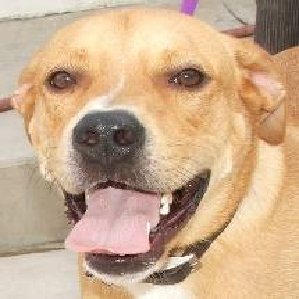

In [31]:
from IPython.display import display

filename = "cats_vs_dogs/test/dog/dog.2001.jpg"
img = load_img(filename, target_size=(299, 299, 3))
display(img)


In [27]:
predict("cats_vs_dogs/test/dog/dog.2001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


0.9960734

In [28]:
predict("cats_vs_dogs/test/cat/cat.2001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


0.047060948

2295


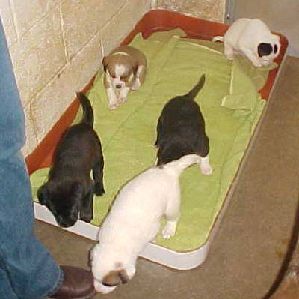

2542


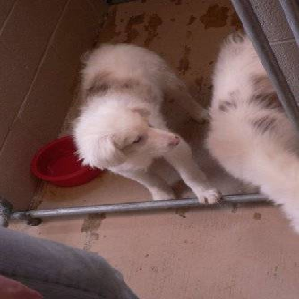

2877


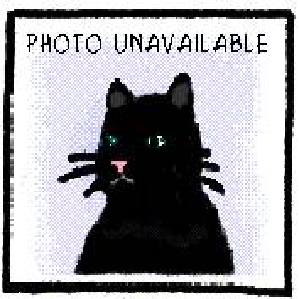

In [34]:
for idx in range(2000, 3000):
    filename = f"cats_vs_dogs/test/dog/dog.{idx}.jpg"

    img = load_img(filename, target_size=(299, 299, 3))
    img = img_to_array(img).reshape(1, 299, 299, 3) / 255

    dog_probability = new_inception_model.predict(img, verbose=0)[0][0]

    if dog_probability < 0.5:
        print(idx)
        display(load_img(filename, target_size=(299, 299, 3)))

### Cats that were incorrectly identified as dogs

2134


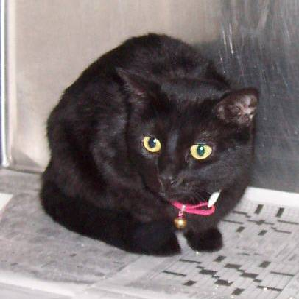

2150


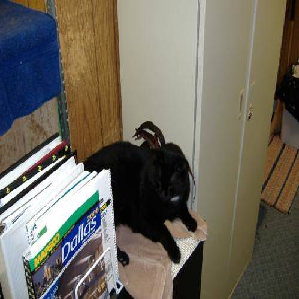

2176


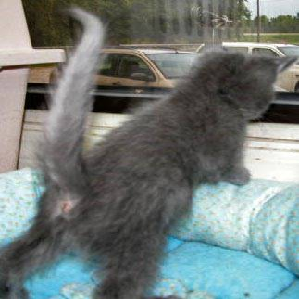

2337


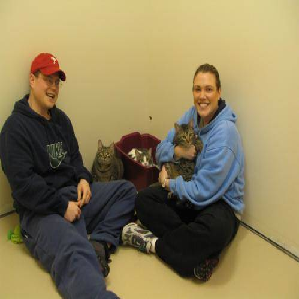

2433


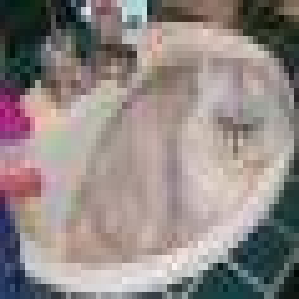

2456


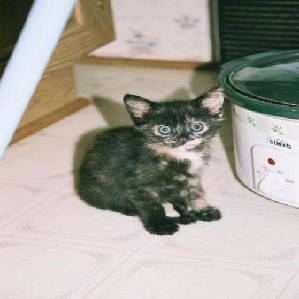

2509


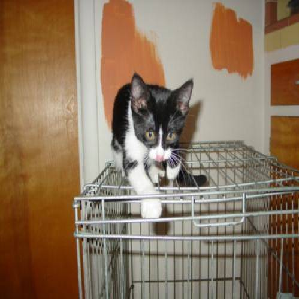

2520


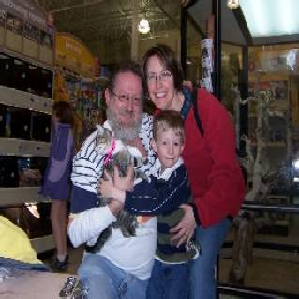

2663


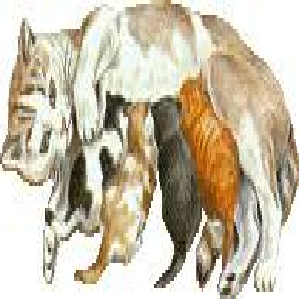

2715


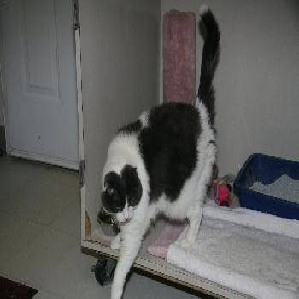

2737


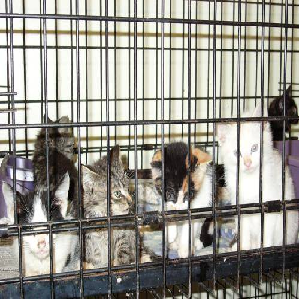

2817


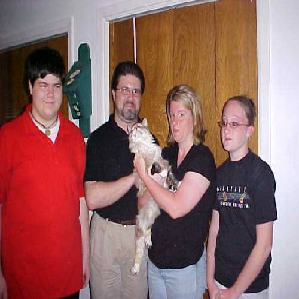

2893


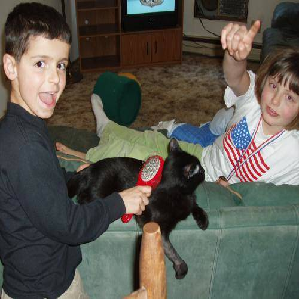

2939


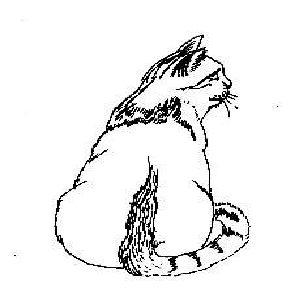

In [35]:
for idx in range(2000, 3000):
    filename = f"cats_vs_dogs/test/cat/cat.{idx}.jpg"

    img = load_img(filename, target_size=(299, 299, 3))
    img = img_to_array(img).reshape(1, 299, 299, 3) / 255

    dog_probability = new_inception_model.predict(img, verbose=0)[0][0]

    if dog_probability > 0.5:
        print(idx)
        display(load_img(filename, target_size=(299, 299, 3)))